In [1]:
import sys
import copy
sys.path.append('..')
import argparse
import umap
import explainers
import evaluate_explanations as Evaluator
import parzen_windows
import numpy as np
import pickle
import sklearn
from load_datasets import *
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [2]:
parser = argparse.ArgumentParser(description='Evaluate some explanations')
parser.add_argument('--dataset', '-d', type=str, required=True,help='dataset name')
parser.add_argument('--algorithm', '-a', type=str, required=True, help='algorithm name')
parser.add_argument('--feat_only', '-f', type=bool, default=True, help='explaination features in inputs only')  
parser.add_argument('--low_dim', '-l', type=bool, default=False, help='EMaP use low dimensional distances')  
args = parser.parse_args("--dataset multi_polarity_books --algorithm l1logreg --feat_only True --low_dim True ".split())
# args = parser.parse_args("--dataset multi_polarity_kitchen --algorithm l1logreg --feat_only True --low_dim True ".split())

In [3]:
dataset = args.dataset
algorithm = args.algorithm
feat_only = args.feat_only
low_dim = args.low_dim  

evaluator = Evaluator.ExplanationEvaluator(classifier_names=[algorithm])
evaluator.load_datasets([dataset])
evaluator.vectorize_and_train()
  
rho = 25
kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
# LIME    
lime_explainer = explainers.GeneralizedLocalExplainer(kernel, explainers.data_labels_distances_mapping_text, num_samples=15000, return_mean=False, verbose=False, return_mapped=True)
lime_explain_fn = lime_explainer.explain_instance
# EMAP
emap_explainer = explainers.EMaPLocalExplainer(kernel, 
                                    base_data = evaluator.train_vectors[dataset].todense(),
                                    clf_fn = evaluator.classifiers[dataset][algorithm],
                                    low_distance = low_dim,           
                                    radius = 1,
                                    return_mean=False, 
                                    verbose=False, 
                                    return_mapped=False)
emap_explain_fn = emap_explainer.explain_instance

Vectorizing...
Done
Training...
multi_polarity_books
Done


In [4]:
import random
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import tree
from sklearn import svm

import pandas as pd

In [5]:
def get_words(line, remove_bigrams=True):
    z = [tuple(x.split(':')) for x in re.findall('\w*?:\d', line)]
    if remove_bigrams:
      z = ' '.join([' '.join([x[0]] * int(x[1])) for x in z if '_' not in x[0]])
    else:
      z = ' '.join([' '.join([x[0]] * int(x[1])) for x in z])
    return z

In [6]:
# PUT POLARITY DATASET PATH HERE
POLARITY_PATH = 'processed_acl/'
remove_bigrams=True

random.seed(1)
name = dataset.split('_')[2]
path_data = POLARITY_PATH + name

pos = []
neg = []
for line in open(os.path.join(path_data, 'negative.review')):
    neg.append(get_words(line, remove_bigrams))
for line in open(os.path.join(path_data, 'positive.review')):
    pos.append(get_words(line, remove_bigrams))

In [7]:
c_features = evaluator.classifiers[dataset][algorithm].coef_.nonzero()[1]
evaluator.inverse_vocabulary[dataset][c_features]

array(['able', 'all', 'also', 'although', 'bad', 'because', 'best',
       'better', 'books', 'boring', 'both', 'disappointed',
       'disappointing', 'easy', 'especially', 'even', 'everything',
       'excellent', 'experience', 'get', 'gives', 'got', 'great',
       'highly', 'historical', 'history', 'how', 'human', 'if', 'instead',
       'just', 'lack', 'life', 'like', 'lives', 'love', 'loved', 'makes',
       'me', 'money', 'much', 'must', 'my', 'new', 'no', 'not', 'nothing',
       'other', 'pages', 'poor', 'poorly', 'read', 'really', 'recommend',
       'seems', 'shows', 'so', 'story', 'their', 'then', 'too',
       'unfortunately', 'used', 'was', 'waste', 'way', 'we', 'well',
       'when', 'wonderful', 'world', 'writing', 'years', 'you'],
      dtype='<U14')

In [14]:
index = 15
raw_label = 1
if raw_label == 1:
    raw_review = pos[index:index+1]
else:
    raw_review = neg[index:index+1]

review = evaluator.vectorizer[dataset].transform(raw_review).todense()
lime_exp = lime_explain_fn(review, raw_label, evaluator.classifiers[dataset][algorithm], num_features= 10, dataset=dataset)
emap_exp = emap_explain_fn(review, raw_label, dataset=dataset)

dict_key = [x[0] for x in lime_exp]
dict_val = [x[1] for x in lime_exp]
lime_explanation_dict = dict(zip(dict_key,dict_val))

dict_key = [x[0] for x in emap_exp]
dict_val = [x[1] for x in emap_exp]
emap_explanation_dict = dict(zip(dict_key,dict_val))

lime_explanation_weight = {}
emap_explanation_weight = {}
for key in list(np.nonzero(review)[1]):
    if key in list(lime_explanation_dict.keys()):
        lime_explanation_weight[evaluator.inverse_vocabulary[dataset][key]] = lime_explanation_dict[key]
    else:
        lime_explanation_weight[evaluator.inverse_vocabulary[dataset][key]] = 0
    if key in list(emap_explanation_dict.keys()):
        emap_explanation_weight[evaluator.inverse_vocabulary[dataset][key]] = emap_explanation_dict[key]
    else:
        emap_explanation_weight[evaluator.inverse_vocabulary[dataset][key]] = 0
        
plot_word = []
plot_emap = []
plot_lime = []
plot_in_c_features = []
score_thres = 0.01
for word in list(evaluator.inverse_vocabulary[dataset][np.nonzero(review)[1]]):
    if emap_explanation_weight[word] > score_thres or lime_explanation_weight[word] > score_thres:
        plot_word.append(word)
        plot_emap.append(emap_explanation_weight[word])
        plot_lime.append(lime_explanation_weight[word])
        if word in list(c_features):
            plot_in_c_features.append('t')
        else:
            plot_in_c_features.append('f')    

plot_df = pd.DataFrame(index = plot_word, columns = ['LIME', 'EMaP'])
plot_df['LIME'] = plot_lime
plot_df['EMaP'] = plot_emap

plot_df

,LIME,EMaP
all,0.033454,0.031573
death,0.000000,0.010411
highly,0.072038,0.061498
story,0.012927,0.017520
way,0.013185,0.008736
you,0.030945,0.030454


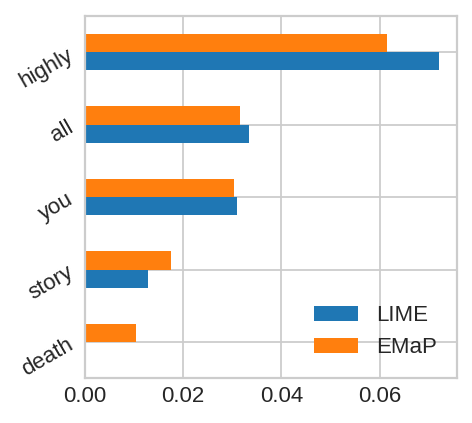

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 160

# dataname = 'kitchen'
dataname = 'book'
if raw_label == 1:
    label_sign = '_pos_'
else:
    label_sign = '_neg_'

fig = plot_df.sort_values('EMaP', ascending=True)[len(plot_df)-5:len(plot_df)].plot(kind="barh", figsize=(3, 3), rot = 30)
file_name = 'new_viz/viz_' + dataname +  label_sign + str(index) + ".png"
# fig.get_figure().tight_layout()
fig.get_figure().savefig(file_name, bbox_inches = "tight")